In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Data

In [6]:
# Load dataset with only the ToTensor transform to compute mean and std
compute_transform = transforms.Compose([transforms.ToTensor()])
dataset = torchvision.datasets.FashionMNIST(root='data', train=True, download=True, transform=compute_transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=1024, num_workers=10, shuffle=True)

mean = 0.0
for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)

mean = mean / len(loader.dataset)

variance = 0.0
for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    variance += ((images - mean.unsqueeze(1))**2).sum([0, 2])
std = torch.sqrt(variance / (len(loader.dataset)*28*28))

print(mean, std)

tensor([0.2860]) tensor([0.3530])


In [7]:
# Load CFashionMNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean,), (std,))])

trainset = torchvision.datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, num_workers=10, shuffle=True)

testset = torchvision.datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, num_workers=10, shuffle = False)

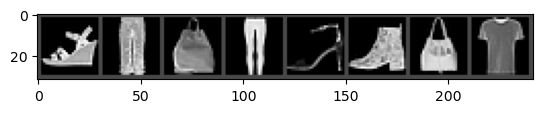

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img*std + mean
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

for i, (images, labels) in enumerate(trainloader, 0):
    imshow(torchvision.utils.make_grid(images[:8]))
    break

### Model

In [9]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)
model = model.to(device)

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [14]:
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_loss = test_loss / len(testloader)

    return test_loss, accuracy

In [15]:
test_loss, test_accuracy = evaluate(model, testloader, criterion)
print(f'test_loss: {test_loss}')
print(f'test_accuracy: {test_accuracy}')

test_loss: 2.3376081943511964
test_accuracy: 5.36


### Train

In [16]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 200

In [17]:
for epoch in range(max_epoch):
    running_loss = 0.0
    running_correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        loss.backward()
        optimizer.step()

    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i+1)
    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/200], Loss: 1.6071, Accuracy: 56.60%, Test Loss: 1.1641, Test Accuracy: 68.85%
Epoch [2/200], Loss: 0.9973, Accuracy: 71.39%, Test Loss: 0.8916, Test Accuracy: 72.08%
Epoch [3/200], Loss: 0.8197, Accuracy: 74.12%, Test Loss: 0.7802, Test Accuracy: 74.41%
Epoch [4/200], Loss: 0.7339, Accuracy: 75.80%, Test Loss: 0.7175, Test Accuracy: 75.64%
Epoch [5/200], Loss: 0.6811, Accuracy: 77.08%, Test Loss: 0.6760, Test Accuracy: 76.64%
Epoch [6/200], Loss: 0.6448, Accuracy: 78.04%, Test Loss: 0.6461, Test Accuracy: 77.57%
Epoch [7/200], Loss: 0.6173, Accuracy: 78.85%, Test Loss: 0.6235, Test Accuracy: 78.29%
Epoch [8/200], Loss: 0.5953, Accuracy: 79.52%, Test Loss: 0.6047, Test Accuracy: 78.80%
Epoch [9/200], Loss: 0.5775, Accuracy: 80.11%, Test Loss: 0.5890, Test Accuracy: 79.35%
Epoch [10/200], Loss: 0.5622, Accuracy: 80.61%, Test Loss: 0.5769, Test Accuracy: 79.88%
Epoch [11/200], Loss: 0.5499, Accuracy: 80.97%, Test Loss: 0.5652, Test Accuracy: 80.10%
Epoch [12/200], Loss: 0.5383, 

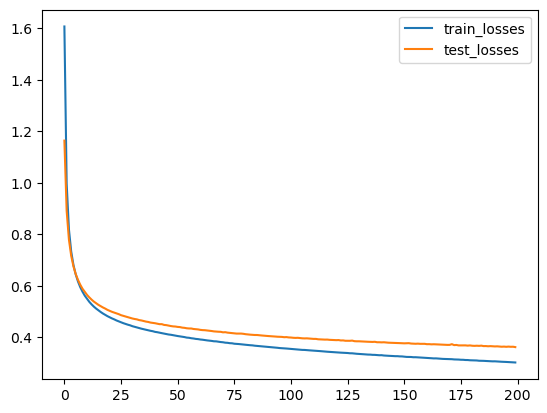

In [18]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

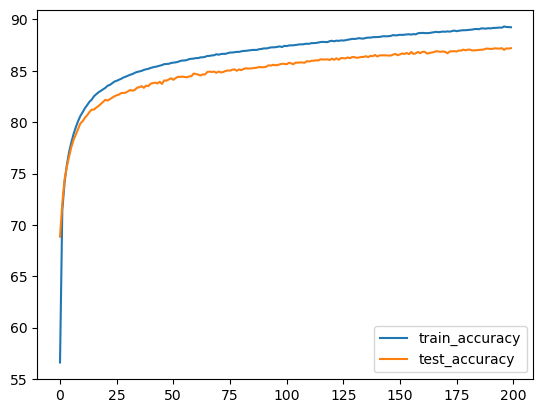

In [19]:
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()